In [254]:
##Carga de librerias
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.ops.init_ops_v2 import Initializer
from numpy.core.fromnumeric import shape
from datetime import datetime

In [255]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()

In [ ]:
#Carga de dataset y división de dataset
data = np.load('proyecto_training_data.npy')

In [ ]:
#Seleccionar la variable X, nombre de variable OverallQual
var_x = data[:, 1]
var_y = data[:, 0]

In [ ]:

class ModeloLineal:
  def __init__(self):
    tf.reset_default_graph()
    self.m = tf.get_variable("pendiente",dtype=tf.float32,shape=[],initializer=tf.zeros_initializer())
    self.b = tf.get_variable("intercepto",dtype=tf.float32,shape=[],initializer=tf.zeros_initializer())
    self.error = tf.get_variable("error",dtype=tf.float32,initializer=0.00)

  def __call__(self,x):
    return self.m*x + self.b

  def actualizar(self,x,y,learning_rate):
    with tf.name_scope("Prediccion"):
      prediccion = self(x)
    with tf.name_scope("Error"):
      error = 1/2*tf.reduce_mean(tf.math.square(y - prediccion))
    with tf.name_scope("Gradiente"):
      gradiente = tf.gradients(error,[self.m,self.b])
    with tf.name_scope("Actualizar"):
      actualizacion_m = tf.assign(self.m, self.m - learning_rate*gradiente[0])
      actualizacion_b = tf.assign(self.b, self.b - learning_rate*gradiente[1])
      actualizar_error = tf.assign(self.error, error)
      actualizacion_parametros = tf.group(actualizacion_m,actualizacion_b, actualizar_error)

    return actualizacion_parametros

In [ ]:
from tensorflow.python.framework.ops import get_default_graph
def EntrenarMiniBatchGradientDescent(x,y,lr,batch_size,epochs):
  tf.reset_default_graph()
  now = datetime.now().strftime("%d%m%Y_%H%M%S")
  dateStr = f"{now}_lr={lr}_batch={batch_size}_epochs={epochs}"
  modelo = ModeloLineal()
  total_iteraciones = int(len(var_x)/batch_size)
  tensor_x = tf.placeholder(tf.float32,[None,1],"tensor_x")
  tensor_y = tf.placeholder(tf.float32,[None,1],"tensor_y")
  prediccion = modelo(tensor_x)
  actualizacion_parametros = modelo.actualizar(tensor_x,tensor_y,lr)
  with tf.train.MonitoredSession() as session:
    writer = tf.summary.FileWriter('logs/'+dateStr,session.graph)
    auxInt = 1
    for epoch in range(epochs): 
      for i in range(total_iteraciones):  #muchas iteraciones por epoch 
        muestra_inicio = i*batch_size
        muestra_fin = muestra_inicio + batch_size
        x_mb =  np.array(var_x[muestra_inicio:muestra_fin]).reshape([-1,1])
        y_mb = np.array(var_y[muestra_inicio:muestra_fin]).reshape([-1,1])
      
        feed_dict = {tensor_x:x_mb, tensor_y:y_mb}
        _,m,b,error_val = session.run([actualizacion_parametros,modelo.m,modelo.b, modelo.error],feed_dict=feed_dict)
        summary = tf.Summary(value=[tf.Summary.Value(tag="MSE", simple_value=error_val)])
        writer.add_summary(summary, auxInt)
        auxInt = auxInt+1

      feed_dict = {tensor_x:np.array(var_x).reshape(-1,1), tensor_y:np.array(var_y).reshape(-1,1)}
      predicciones = session.run(prediccion,feed_dict=feed_dict)

    pendiente_final,intercepto_final = session.run([modelo.m,modelo.b],feed_dict=feed_dict)
  return pendiente_final,intercepto_final


In [ ]:
#Primer experimento epochs = 1, lr= 0.0001, batch_size = 25
#Hipotesis 1 iteracion con tamaño de batch pequeño, learning rate bajo -> error alto
EntrenarMiniBatchGradientDescent(var_x,var_y,0.0001,25,1)

#Segundo experimento epochs = 5, lr= 0.1, batch_size = 25
#Hipotesis 2 iteracion con tamaño de batch pequeño, learning rate cercano a 1 -> error alto
EntrenarMiniBatchGradientDescent(var_x,var_y,0.1,25,5)

#Tercer experimento epochs = 5, lr= 0.01, batch_size = 25
#Hipotesis 3 iteracion con tamaño de batch pequeño, learning rate más pequeño
#que hipotesis anterior -> mejora el error
EntrenarMiniBatchGradientDescent(var_x,var_y,0.01,25,5)

#Cuarto experimento epochs = 10, lr= 0.00001, batch_size = 25
#Hipotesis 4 iteracion con tamaño de batch pequeño,
#learning rate bajo, 10 iteraciones en total -> error disminuye lentamente
EntrenarMiniBatchGradientDescent(var_x,var_y,0.0001,25,10)

#Quinto experimento epochs = 10, lr= 0.00001, batch_size = 150
#Hipotesis 5, se aumenta tamaño de batch -> error disminuye rapidamente
EntrenarMiniBatchGradientDescent(var_x,var_y,0.0001,150,10)

#Sexto experimento epochs = 10, lr= 0.01, batch_size = 150
#Hipotesis 6, se aumenta el learning rate -> error aumenta exponencialmente
EntrenarMiniBatchGradientDescent(var_x,var_y,0.01,150,10)

#Septimo experimento epochs = 10, lr= 0.01, batch_size = 1000
#Hipotesis 7, se aumenta el learning rate, el número de iteraciones
#y el tamaño del batch -> error aumenta exponencialmente
EntrenarMiniBatchGradientDescent(var_x,var_y,0.01,1000,10)

#Octavo experimento epochs = 5, lr= 0.000001, batch_size = 10
#Hipotesis 8, se busca el mejor modelo con un learning rate bajo
EntrenarMiniBatchGradientDescent(var_x,var_y,0.000001,100,5)

#Noveno experimento epochs = 5, lr= 0.00001, batch_size = 100
#Hipotesis 9, se busca el mejor modelo, experimentando con el lr
EntrenarMiniBatchGradientDescent(var_x,var_y,0.00001,100,5)

#Decimo experimento epochs = 5, lr= 0.0001, batch_size = 100
#Hipotesis 10, se busca el mejor modelo, experimentando con el lr
EntrenarMiniBatchGradientDescent(var_x,var_y,0.0001,100,5)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Graph was finalized.
INF

(7293.937, 1102.4858)

**Resultado de hipotesis 1**
EntrenarMiniBatchGradientDescent(var_x,var_y,0.0001,25,1)
Efectivamente se tuvo un error alto

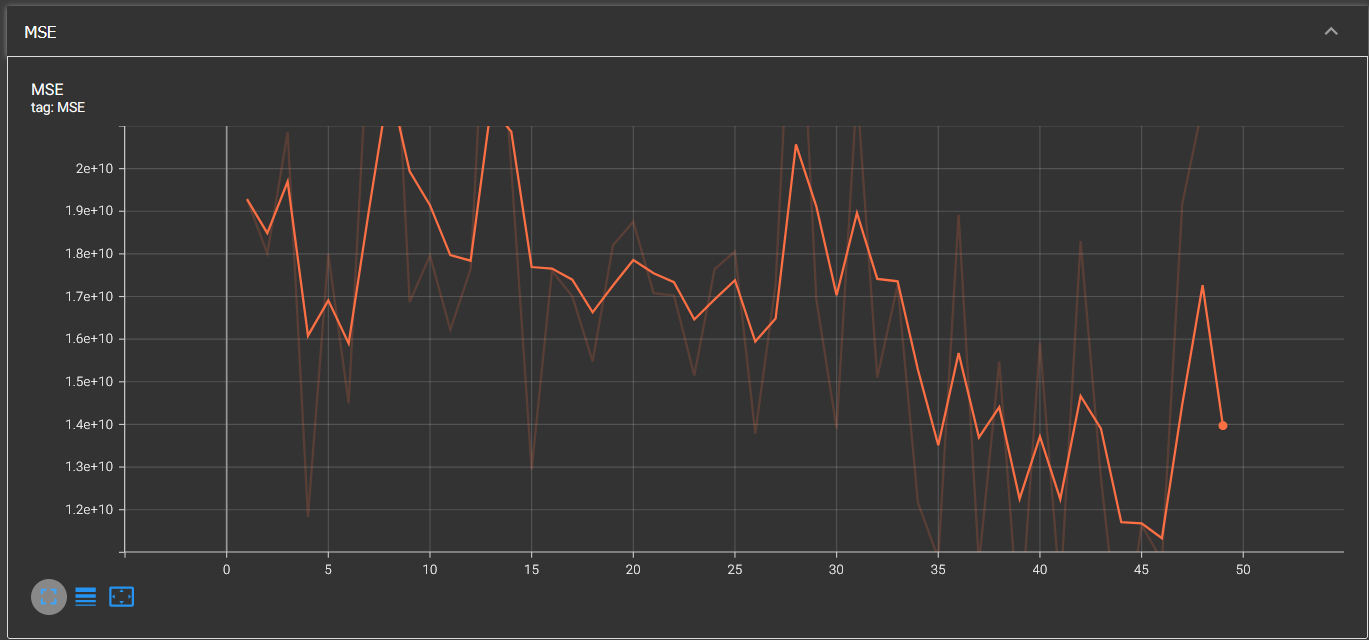

**Resultado de hipotesis 2**
EntrenarMiniBatchGradientDescent(var_x,var_y,0.1,25,5)
Efectivamente se tiene un error alto 

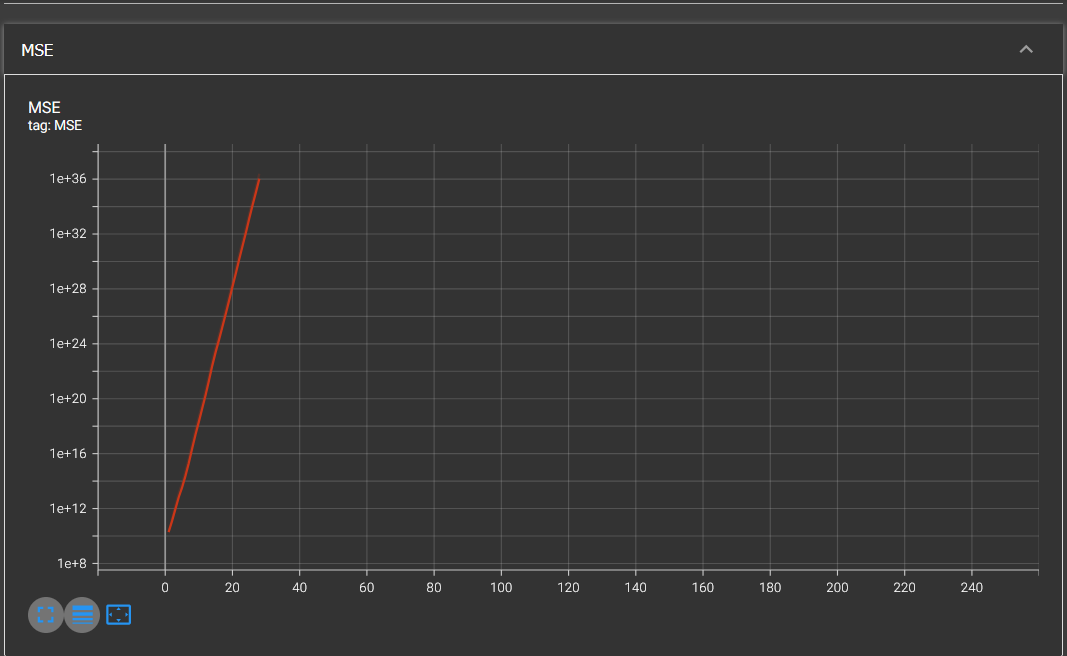

**Resultado de hipotesis 3**
EntrenarMiniBatchGradientDescent(var_x,var_y,0.01,25,5)
Al utilizar un learning rate menor mejor la tendencia del error

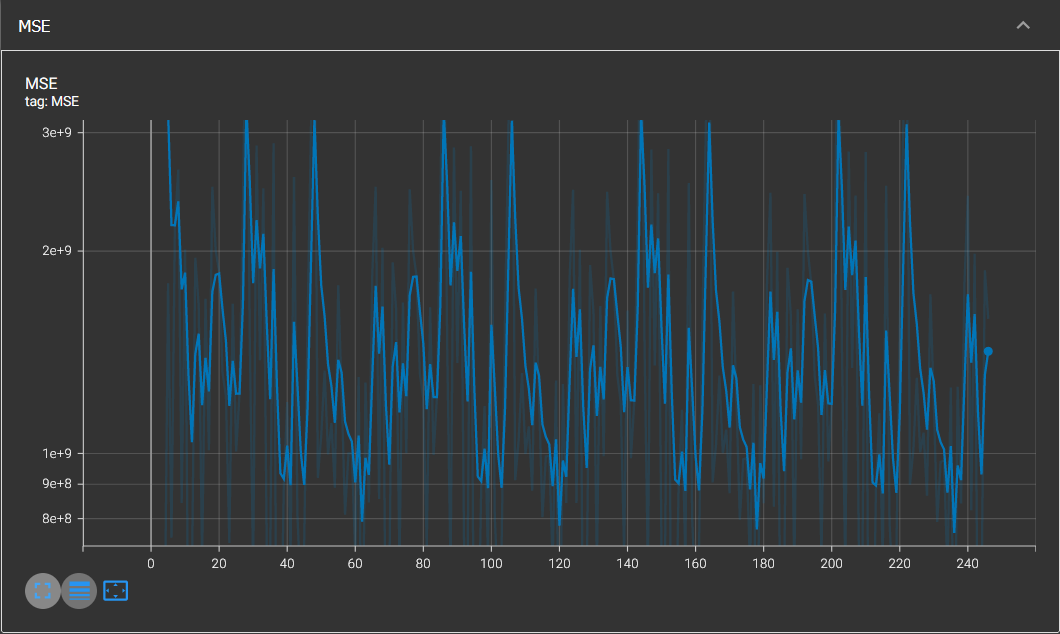

**Resultado de la hipotesis 4**
EntrenarMiniBatchGradientDescent(var_x,var_y,0.0001,25,10)
Efectivamente al utilizar un learning rate más bajo disminuye el error
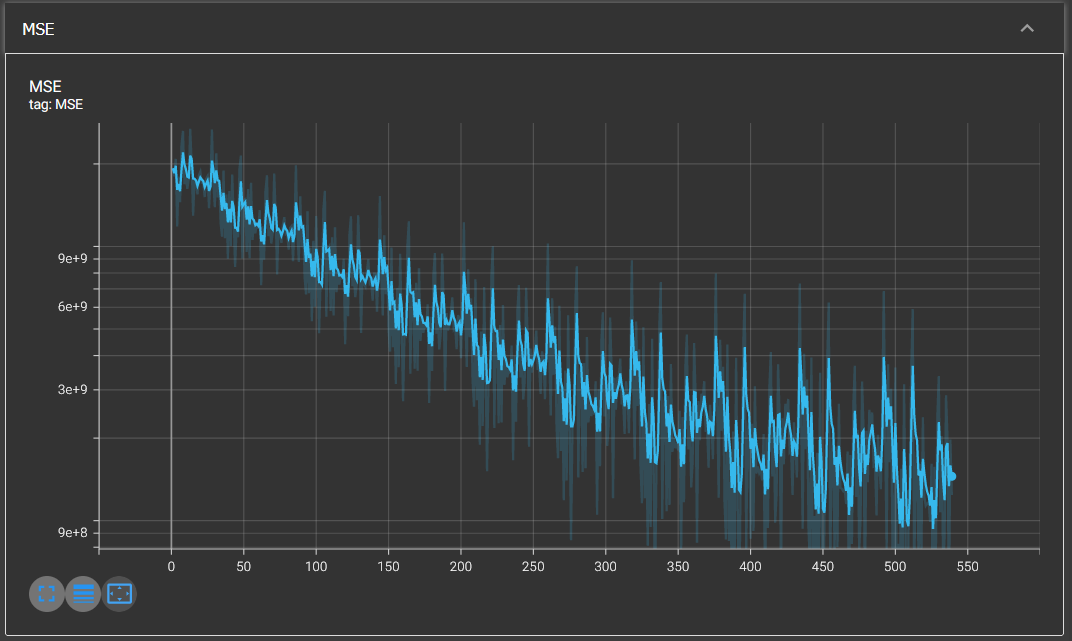

**Resultado de la hipotesis 5**
 EntrenarMiniBatchGradientDescent(var_x,var_y,0.0001,150,10) 
El error no disminuyo rapidamente, el error es más cercano a cero, sin embargo no se redujo rapidamente en el número de iteraciones

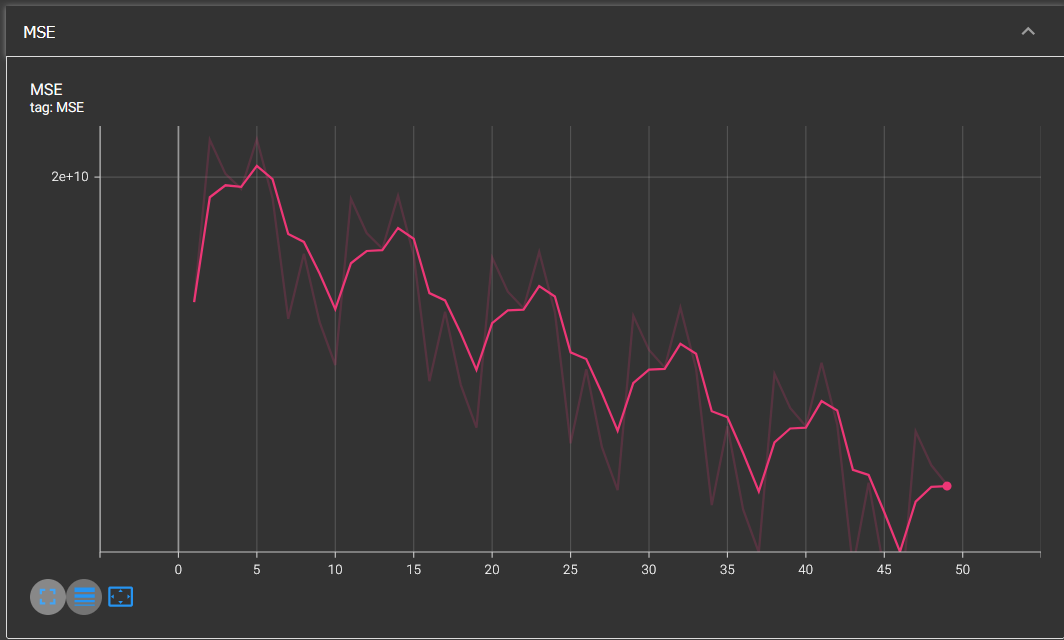

**Resultado de la hipotesis 6** EntrenarMiniBatchGradientDescent(var_x,var_y,0.01,150,10) 


El resultado muestra que con un número de batch grande y aumentando ligeramente el learning rate, no se aumento el error, al contrario, el error disminuyo de forma más rapida

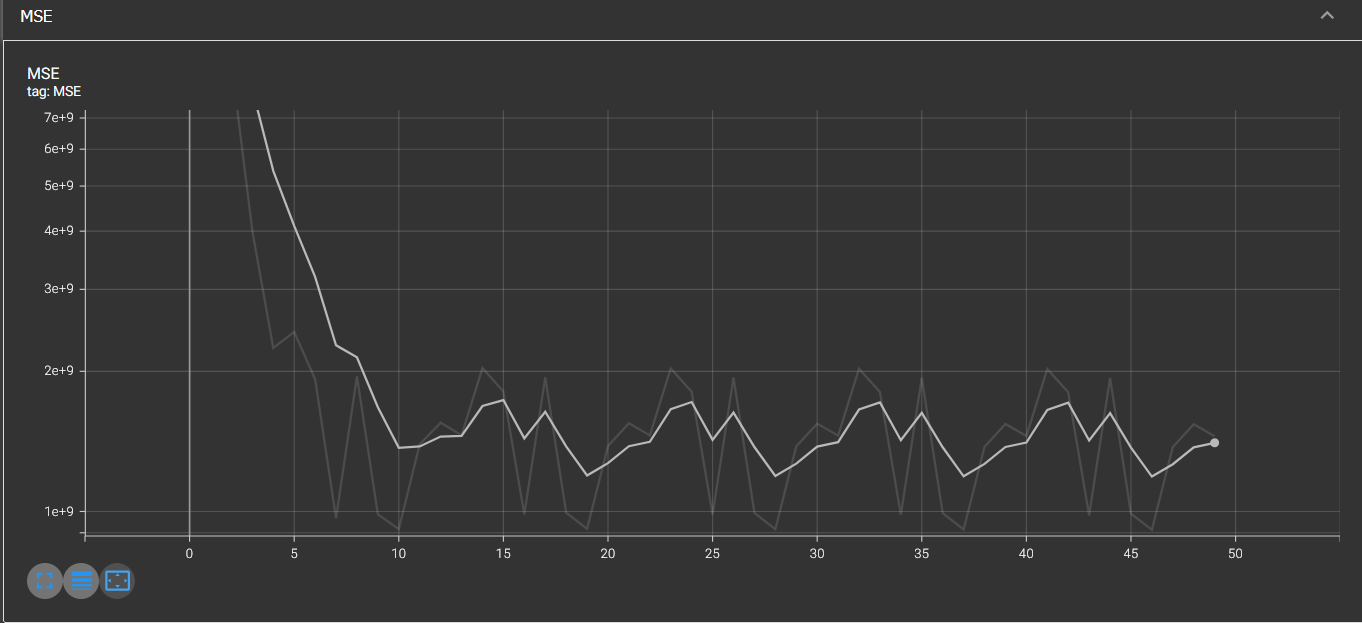

**Resultado hipotesis 7**
EntrenarMiniBatchGradientDescent(var_x,var_y,0.01,1000,10)

Efectivamente el utilizar un número de itereraciones alto, un tamaño de batch alto y un learning rate cercano a 1 no brinda resultados

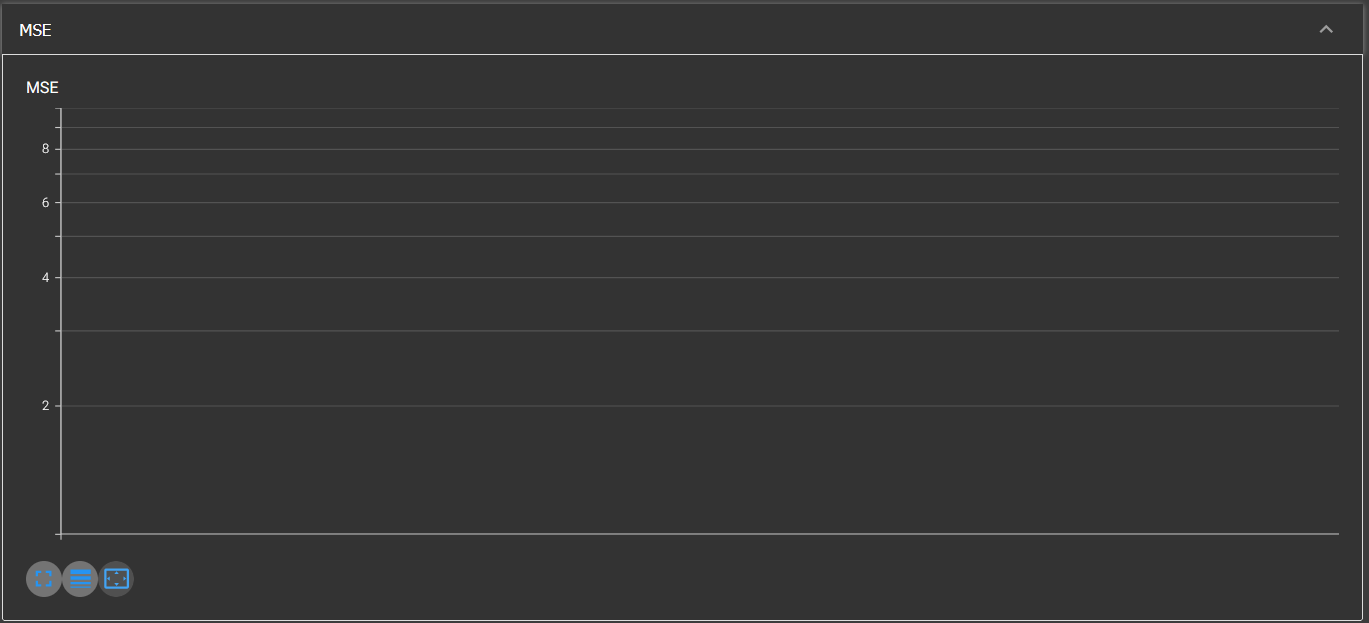



**Resultado de hipotesis 8**
EntrenarMiniBatchGradientDescent(var_x,var_y,0.000001,100,5)

El experimento determino que utilizar un learning rate muy pequeño provoca que el error se comporte de forma constante.

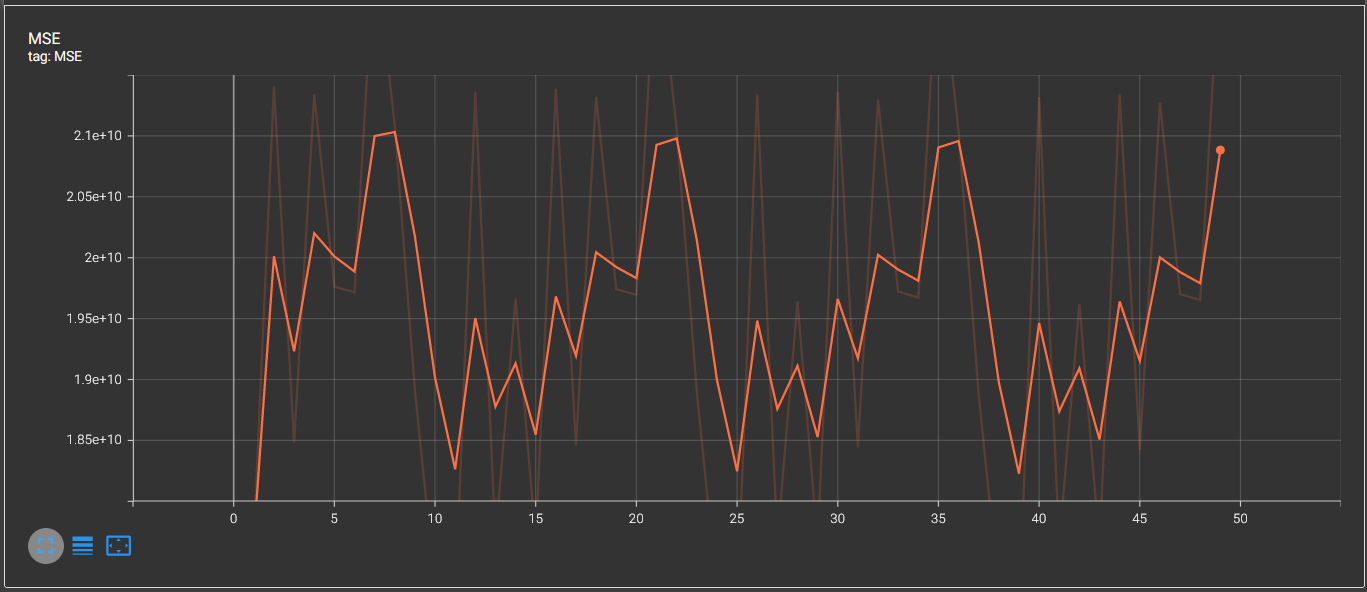

**Resultado de hipotesis 9**
EntrenarMiniBatchGradientDescent(var_x,var_y,0.00001,100,5)

El experimento muestra que aumentar ligeramente el learning rate mantiene el error de forma constante.

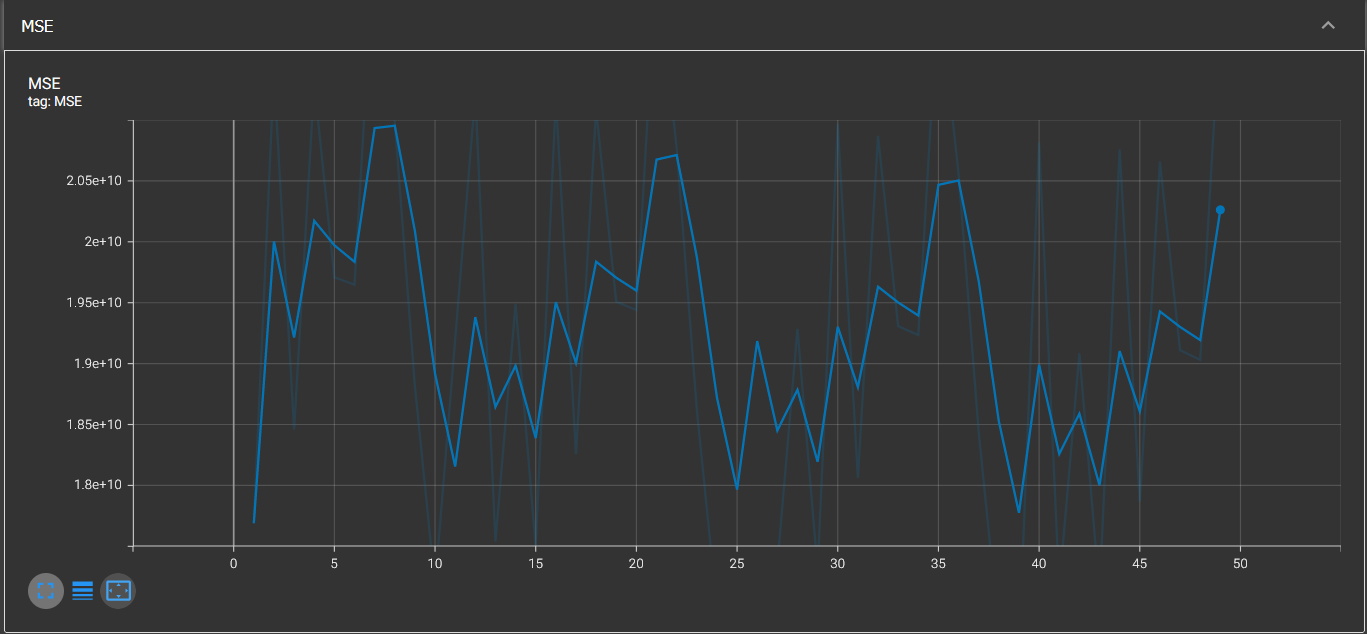

**Resultado de la hipotesis 10**
EntrenarMiniBatchGradientDescent(var_x,var_y,0.0001,100,5)

Este experimento muestra una tendencia a la baja del error respecto al anterior, variando el learning rate

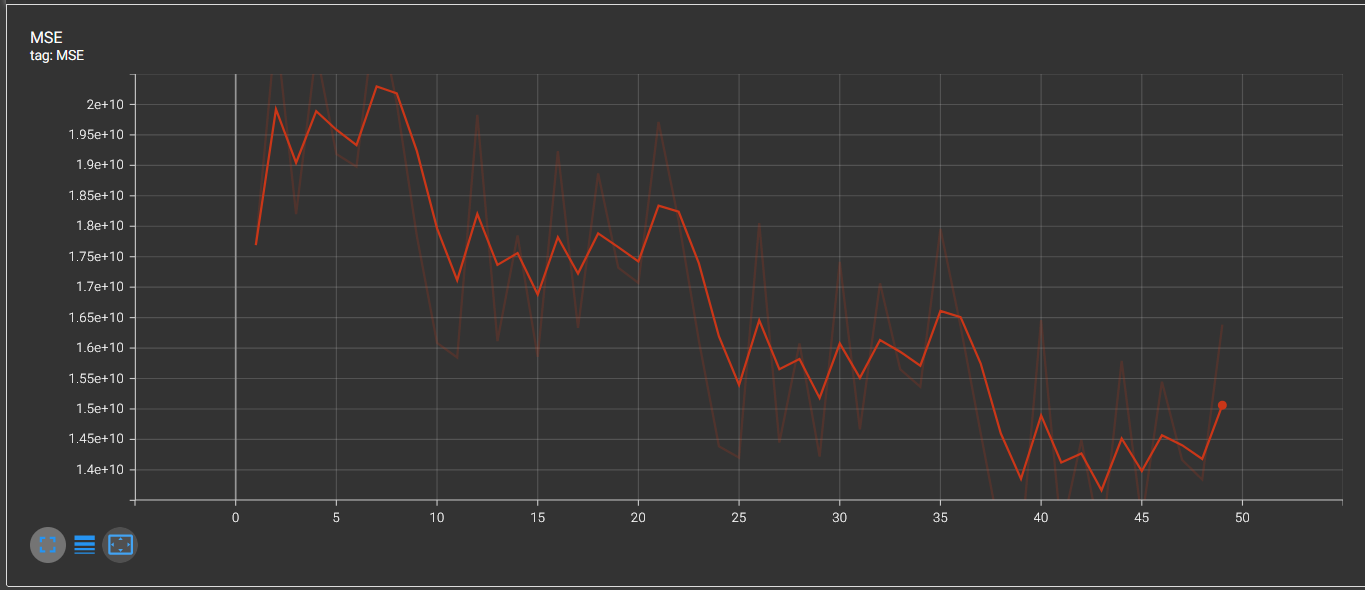

##Conclusión

El mejor resultado se obtuvo con el modelo
**EntrenarMiniBatchGradientDescent(var_x,var_y,0.0001,25,10)**
